# **Template OP on salish**

In [1]:
%matplotlib inline
import sys
import xarray as xr
import os
from matplotlib import pyplot as plt, animation, rc
import matplotlib.colors as mcolors
from dateutil.parser import parse

from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ErrorCode, AdvectionRK4, AdvectionRK4_3D

rc('animation', html='html5')
from IPython.display import Image

sys.path.append('/home/jvalenti/MOAD/analysis-jose/notebooks/parcels')
from Kernels import DeleteParticle, Buoyancy
from OP_functions import *

## Definitions

In [2]:
# Set Time length [days] and timestep [seconds]
length = 2
duration = timedelta(days=length)
dt = 90 #toggle between - or + to pick backwards or forwards

In [3]:
# Set some particle definitions
N = 6 # number of deploying locations
n = 100 # 1000   # number of particles per location
# Define Gaussian point cloud in the horizontal
r = 1000   # radius of particle cloud [m]
deg2m = 111000 * np.cos(50 * np.pi / 180)
var = (r / (deg2m * 3))**2
x_offset, y_offset = np.random.multivariate_normal([0, 0], [[var, 0], [0, var]], [n,N]).T
# Set a uniform distribution in depth, from dmin to dmax
dmin = 0
dmax = 20
zvals = dmin + np.random.random_sample([n,N]).T*(dmax-dmin)

In [4]:
# Set location of deployed particles
lon = np.zeros([N,n])
lat = np.zeros([N,n])
# Execute run
clon, clat = [-123.901172,-125.155849,-123.207648,-122.427508,-123.399769,-123.277731], [49.186308,49.975326,49.305448,47.622403,48.399420,49.11602]  # choose horizontal centre of the particle cloud
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])
z = zvals

In [5]:
#Set start date time and the name of the output file
start = datetime(2018, 1, 17) #Start date
name = 'Test-template' #name output file
daterange = [start+timedelta(days=i) for i in range(length)]
paths = path(0)
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['out'], fn)
print(outfile)

/home/jvalenti/MOAD/analysis-jose/notebooks/results/Test-template20180117_1n_20180119_1n.nc


## Simulation

In [6]:
#Fill in the list of variables that you want to use as fields
varlist=['U','V','W']
filenames,variables,dimensions=filename_set(start,length,varlist,0)

In [7]:
#Load Salish output as fields
field_set = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True)
pset = ParticleSet.from_list(field_set, JITParticle, lon=lon, lat=lat, depth=z, time=start+timedelta(hours=2))

#p_flt = pset.Kernel(Buoyancy) #uncomment if you want to use additional kernels, also change the value of pset.Kernel to "AdvectionRK4_3D + p_flt"
#pset.computeTimeChunk(allow_time_extrapolation=1)
pset.execute(
    pset.Kernel(AdvectionRK4_3D), runtime=duration, dt=dt,
    output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=1)),
    recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
)

         It will be opened with no decoding. Filling values might be wrongly parsed.
INFO: Compiled ArrayJITParticleAdvectionRK4_3D ==> /tmp/parcels-2894/lib1243c54beaa44b6e364c00ac2d12d9aa_0.so


KeyboardInterrupt: 

In [ ]:
#coords,mask,ds = output(outfile)

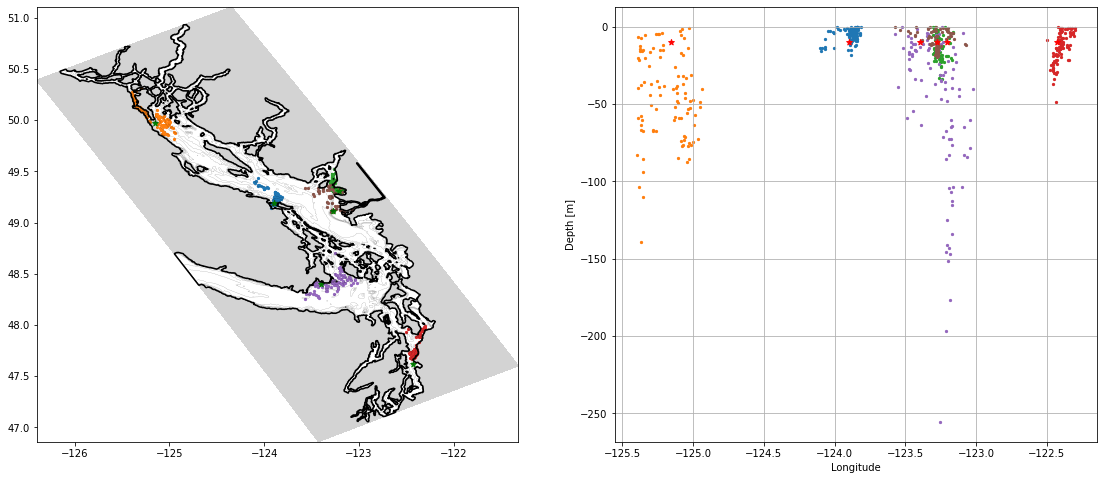

In [8]:
visual(outfile,N,n,clon,clat,dmin,dmax,-1,-1,0)

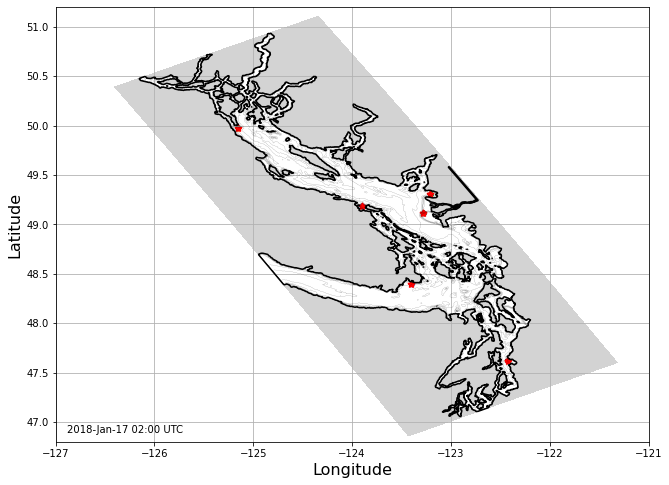

In [9]:
fps=1
mapanimation(outfile,N,n,clon,clat,dmin,dmax,fps,0)

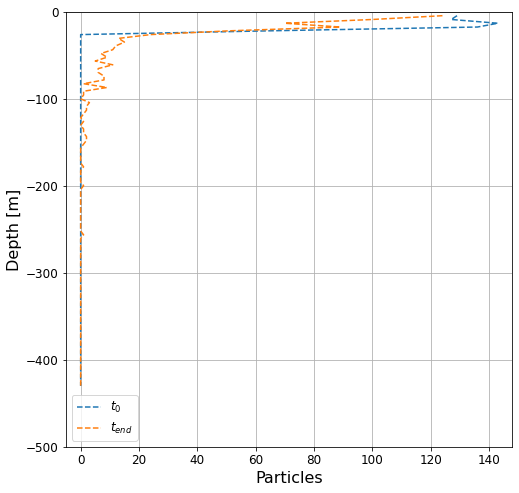

In [10]:
profile(N,n,length,outfile,100,0)